In [6]:
import numpy as np
import pandas as pd
import torch
import torchvision.transforms as transforms
import cv2
import matplotlib.pyplot as plt


In [7]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

dataset_path = "/kaggle/input/eurosat-rgb"
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

dataset = ImageFolder(root=dataset_path, transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)


In [8]:
import os

dataset_path = "/kaggle/input/eurosat-rgb/EuroSAT_RGB"
print(os.listdir(dataset_path))  # Should show class names like 'Forest', 'River', etc.


['SeaLake', 'Highway', 'River', 'Pasture', 'Industrial', 'Residential', 'PermanentCrop', 'AnnualCrop', 'Forest', 'HerbaceousVegetation']


In [5]:
from torch.utils.data import random_split

# Define dataset sizes
train_size = int(0.7 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size

# Split dataset
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")


Train: 18900, Val: 5400, Test: 2700


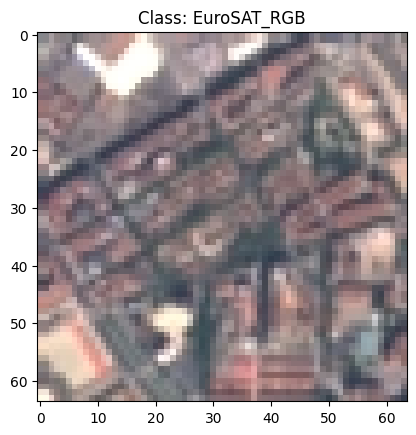

In [6]:
# Function to display images
def imshow(img, label):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(f"Class: {dataset.classes[label]}")
    plt.show()

# Fetch a batch of images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Show first image
imshow(images[0], labels[0])


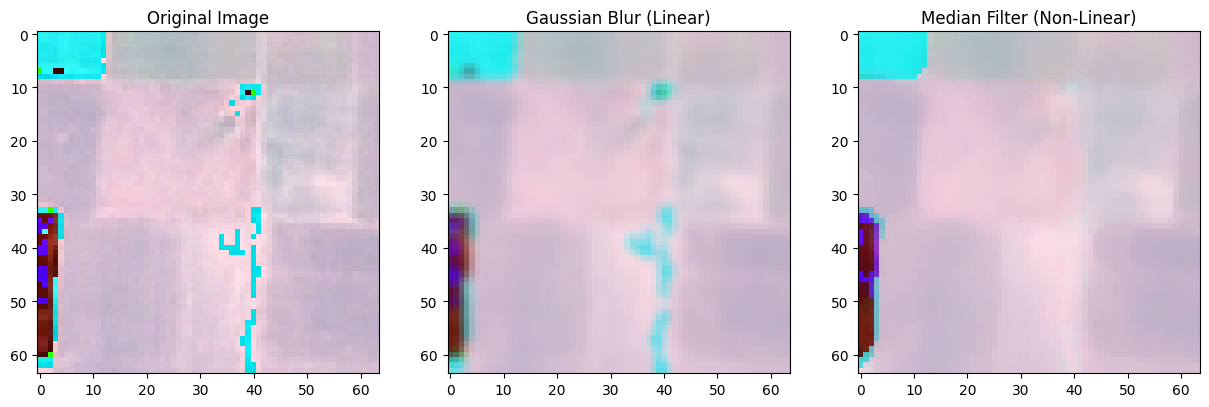

In [11]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from torchvision.transforms import functional as TF

# Function to apply filtering
def apply_filters(image):
    # Convert tensor to NumPy
    image = TF.to_pil_image(image)  # Convert tensor to PIL
    image = np.array(image)  # Convert PIL to NumPy

    # Linear Filtering: Gaussian Blur
    gaussian_filtered = cv2.GaussianBlur(image, (5, 5), 1)

    # Non-Linear Filtering: Median Filter
    median_filtered = cv2.medianBlur(image, 5)

    return image, gaussian_filtered, median_filtered

# Get a sample image from the dataset
sample_image, _ = dataset[0]  # Taking first image
original, gaussian, median = apply_filters(sample_image)

# Plot the results
fig, ax = plt.subplots(1, 3, figsize=(15,5))
ax[0].imshow(original)
ax[0].set_title("Original Image")
ax[1].imshow(gaussian)
ax[1].set_title("Gaussian Blur (Linear)")
ax[2].imshow(median)
ax[2].set_title("Median Filter (Non-Linear)")
plt.show()


In [8]:
import os
import cv2
import numpy as np
from tqdm import tqdm
from torchvision.transforms import functional as TF
from PIL import Image

# Paths
data_dir = "/kaggle/input/eurosat-rgb/EuroSAT_RGB"
output_dir = "Filtered_Images"
os.makedirs(output_dir, exist_ok=True)

# Apply filters to all images in each category
for category in tqdm(os.listdir(data_dir)):
    class_dir = os.path.join(data_dir, category)
    output_class_dir = os.path.join(output_dir, category)
    os.makedirs(output_class_dir, exist_ok=True)

    for img_name in os.listdir(class_dir):
        img_path = os.path.join(class_dir, img_name)
        img = Image.open(img_path).convert("RGB")  # Open image
        img_np = np.array(img)  # Convert to NumPy array

        # Apply Gaussian Blur (Linear)
        gaussian_filtered = cv2.GaussianBlur(img_np, (5, 5), 1)

        # Apply Median Filter (Non-Linear)
        median_filtered = cv2.medianBlur(img_np, 5)

        # Save filtered images
        cv2.imwrite(os.path.join(output_class_dir, f"gaussian_{img_name}"), cv2.cvtColor(gaussian_filtered, cv2.COLOR_RGB2BGR))
        cv2.imwrite(os.path.join(output_class_dir, f"median_{img_name}"), cv2.cvtColor(median_filtered, cv2.COLOR_RGB2BGR))

print("Noise Reduction Completed for Full Dataset!")


100%|██████████| 10/10 [01:49<00:00, 10.97s/it]

Noise Reduction Completed for Full Dataset!


In [9]:
import os
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from PIL import Image

# Paths
filtered_dir = "Filtered_Images"
original_dir = "/kaggle/input/eurosat-rgb/EuroSAT_RGB"

# Initialize lists to store results
results = []

def evaluate_filters(original, filtered):
    original_gray = cv2.cvtColor(original, cv2.COLOR_RGB2GRAY)
    filtered_gray = cv2.cvtColor(filtered, cv2.COLOR_RGB2GRAY)

    psnr_value = psnr(original_gray, filtered_gray)
    ssim_value = ssim(original_gray, filtered_gray)

    return psnr_value, ssim_value

# Loop through categories
for category in tqdm(os.listdir(original_dir)):
    class_dir = os.path.join(original_dir, category)
    filtered_class_dir = os.path.join(filtered_dir, category)

    for img_name in os.listdir(class_dir):
        # Load original image
        img_path = os.path.join(class_dir, img_name)
        img = Image.open(img_path).convert("RGB")
        img_np = np.array(img)

        # Load Gaussian filtered image
        gaussian_path = os.path.join(filtered_class_dir, f"gaussian_{img_name}")
        gaussian_img = cv2.imread(gaussian_path)
        gaussian_img = cv2.cvtColor(gaussian_img, cv2.COLOR_BGR2RGB)

        # Load Median filtered image
        median_path = os.path.join(filtered_class_dir, f"median_{img_name}")
        median_img = cv2.imread(median_path)
        median_img = cv2.cvtColor(median_img, cv2.COLOR_BGR2RGB)

        # Evaluate filters
        psnr_gaussian, ssim_gaussian = evaluate_filters(img_np, gaussian_img)
        psnr_median, ssim_median = evaluate_filters(img_np, median_img)

        # Store results
        results.append([category, img_name, psnr_gaussian, ssim_gaussian, psnr_median, ssim_median])

# Convert to DataFrame
df = pd.DataFrame(results, columns=["Category", "Image", "PSNR_Gaussian", "SSIM_Gaussian", "PSNR_Median", "SSIM_Median"])

# Save results
df.to_csv("filter_evaluation_results.csv", index=False)
print("Filter evaluation completed! Results saved in filter_evaluation_results.csv")


100%|██████████| 10/10 [01:11<00:00,  7.16s/it]

Filter evaluation completed! Results saved in filter_evaluation_results.csv


In [10]:
import pandas as pd

# Load the evaluation results
df = pd.read_csv("filter_evaluation_results.csv")

# Compute mean values
mean_psnr_gaussian = df["PSNR_Gaussian"].mean()
mean_ssim_gaussian = df["SSIM_Gaussian"].mean()
mean_psnr_median = df["PSNR_Median"].mean()
mean_ssim_median = df["SSIM_Median"].mean()

# Print comparison results
print("Mean PSNR & SSIM Comparison")
print(f"Gaussian Blur - Mean PSNR: {mean_psnr_gaussian:.2f}, Mean SSIM: {mean_ssim_gaussian:.3f}")
print(f"Median Filter - Mean PSNR: {mean_psnr_median:.2f}, Mean SSIM: {mean_ssim_median:.3f}")


Mean PSNR & SSIM Comparison
Gaussian Blur - Mean PSNR: 36.34, Mean SSIM: 0.911
Median Filter - Mean PSNR: 34.18, Mean SSIM: 0.831


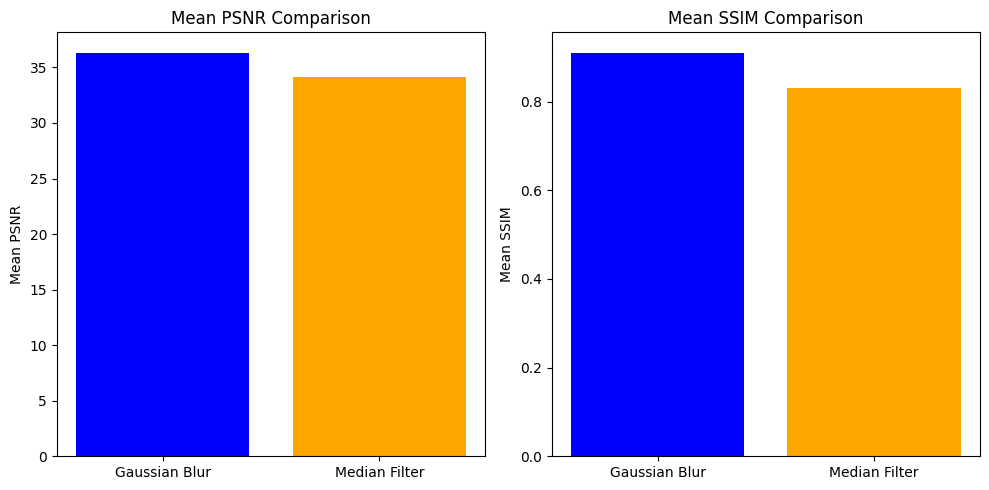

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the evaluation results
df = pd.read_csv("filter_evaluation_results.csv")

# Compute mean values
mean_psnr_gaussian = df["PSNR_Gaussian"].mean()
mean_ssim_gaussian = df["SSIM_Gaussian"].mean()
mean_psnr_median = df["PSNR_Median"].mean()
mean_ssim_median = df["SSIM_Median"].mean()

# Data for visualization
labels = ["Gaussian Blur", "Median Filter"]
psnr_values = [mean_psnr_gaussian, mean_psnr_median]
ssim_values = [mean_ssim_gaussian, mean_ssim_median]

# Plot PSNR comparison
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.bar(labels, psnr_values, color=["blue", "orange"])
plt.ylabel("Mean PSNR")
plt.title("Mean PSNR Comparison")

# Plot SSIM comparison
plt.subplot(1, 2, 2)
plt.bar(labels, ssim_values, color=["blue", "orange"])
plt.ylabel("Mean SSIM")
plt.title("Mean SSIM Comparison")

# Show plots
plt.tight_layout()
plt.show()


For segmentation, Gaussian Blur is preferred because: ✅ It reduces high-frequency noise while preserving general shapes.
✅ It smooths textures and helps segmentation algorithms (like U-Net or thresholding) detect clear boundaries.
❌ Median filtering can distort edges, making it less suitable for precise segmentation.

In [16]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from skimage.segmentation import felzenszwalb
from sklearn.cluster import MeanShift, estimate_bandwidth

# Set dataset path (Using only Gaussian-Filtered Images)
dataset_path = "Filtered_Images"
output_path = "Segmented_Images"

# Define the specific category to process
category = "Forest"  # Change this to process a different category

# Paths for this category
category_path = os.path.join(dataset_path, category)
output_category_path = os.path.join(output_path, category)

# Create output directory if not exists
if not os.path.exists(output_category_path):
    os.makedirs(output_category_path)

# Resize images for faster processing
IMG_SIZE = (32, 32)

# Function to apply K-Means Segmentation
def kmeans_segmentation(image, k=3):
    image_resized = cv2.resize(image, IMG_SIZE)  # Reduce image size
    pixel_values = image_resized.reshape((-1, 3))
    pixel_values = np.float32(pixel_values)

    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(pixel_values)
    segmented_image = labels.reshape(image_resized.shape[:2]).astype(np.float32)  # Convert to float

    return cv2.resize(segmented_image, (64, 64), interpolation=cv2.INTER_NEAREST)  # Nearest-neighbor for labels


# Function to apply Mean Shift Segmentation
def mean_shift_segmentation(image):
    image_resized = cv2.resize(image, IMG_SIZE)  # Reduce size for faster Mean Shift
    flat_image = image_resized.reshape((-1, 3))

    bandwidth = estimate_bandwidth(flat_image, quantile=0.1, n_samples=100)  # Use fewer samples
    mean_shift = MeanShift(bandwidth=bandwidth, bin_seeding=True)

    labels = mean_shift.fit_predict(flat_image)
    segmented_image = labels.reshape(image_resized.shape[:2]).astype(np.float32)  # Convert to float

    return cv2.resize(segmented_image, (64, 64), interpolation=cv2.INTER_NEAREST)  # Prevents label blending

# Function to apply Graph-Based Segmentation (Felzenszwalb)
def graph_based_segmentation(image):
    image_resized = cv2.resize(image, IMG_SIZE)  # Reduce size for speed
    segments = felzenszwalb(image_resized, scale=50, sigma=0.5, min_size=30)

    return cv2.resize(segments.astype(np.float32), (64, 64), interpolation=cv2.INTER_NEAREST)  # Convert & resize


# Process images in the selected category
for filename in os.listdir(category_path):
    if filename.startswith("gaussian_"):
        img_path = os.path.join(category_path, filename)
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Apply Segmentation
        kmeans_result = kmeans_segmentation(image)
        mean_shift_result = mean_shift_segmentation(image)
        graph_result = graph_based_segmentation(image)

        # Save results
        filename_clean = filename.replace("gaussian_", "")
        plt.imsave(os.path.join(output_category_path, f"{filename_clean}_kmeans.png"), kmeans_result, cmap="viridis")
        plt.imsave(os.path.join(output_category_path, f"{filename_clean}_meanshift.png"), mean_shift_result, cmap="viridis")
        plt.imsave(os.path.join(output_category_path, f"{filename_clean}_graph.png"), graph_result, cmap="viridis")

        print(f"Processed {filename_clean} in {category}")

print(f"Segmentation complete for category: {category}! Results saved in 'Segmented_Images/{category}'")


Processed Forest_1848.jpg in Forest
Processed Forest_1560.jpg in Forest
Processed Forest_1833.jpg in Forest
Processed Forest_1641.jpg in Forest
Processed Forest_1132.jpg in Forest
Processed Forest_411.jpg in Forest
Processed Forest_1125.jpg in Forest
Processed Forest_12.jpg in Forest
Processed Forest_2797.jpg in Forest
Processed Forest_1859.jpg in Forest
Processed Forest_1250.jpg in Forest
Processed Forest_2005.jpg in Forest
Processed Forest_886.jpg in Forest
Processed Forest_1630.jpg in Forest
Processed Forest_1915.jpg in Forest
Processed Forest_2698.jpg in Forest
Processed Forest_1681.jpg in Forest
Processed Forest_1021.jpg in Forest
Processed Forest_1409.jpg in Forest
Processed Forest_1812.jpg in Forest
Processed Forest_2846.jpg in Forest
Processed Forest_2806.jpg in Forest
Processed Forest_1127.jpg in Forest
Processed Forest_891.jpg in Forest
Processed Forest_659.jpg in Forest
Processed Forest_2745.jpg in Forest
Processed Forest_1271.jpg in Forest
Processed Forest_2585.jpg in Fores

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.segmentation import slic
from skimage.color import rgb2gray
from skimage.filters import threshold_otsu

# Paths
dataset_path = "Filtered_Images"
gt_output_path = "Ground_Truth"

# Create output directory
if not os.path.exists(gt_output_path):
    os.makedirs(gt_output_path)

# Function to generate GT masks using thresholding
def generate_threshold_mask(image):
    gray_image = rgb2gray(image)  # Convert to grayscale
    thresh = threshold_otsu(gray_image)  # Compute optimal threshold
    binary_mask = gray_image > thresh  # Apply threshold
    return binary_mask.astype(np.uint8)  # Convert to 0-1 mask

# Function to generate GT masks using SLIC (Superpixels)
def generate_slic_mask(image, n_segments=100):
    segments = slic(image, n_segments=n_segments, compactness=10)
    return segments.astype(np.uint8)  # Convert to labels

# Process dataset category-wise
for category in os.listdir(dataset_path):
    category_path = os.path.join(dataset_path, category)
    gt_category_path = os.path.join(gt_output_path, category)

    # Create output directory for ground truth masks
    if not os.path.exists(gt_category_path):
        os.makedirs(gt_category_path)

    for filename in os.listdir(category_path):
        if filename.startswith("gaussian_"):  # Only process Gaussian-filtered images
            img_path = os.path.join(category_path, filename)
            image = cv2.imread(img_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            # Generate both types of ground truth masks
            threshold_mask = generate_threshold_mask(image)
            slic_mask = generate_slic_mask(image)

            # Save ground truth masks
            plt.imsave(os.path.join(gt_category_path, f"{filename.replace('gaussian_', '')}_thresh.png"), threshold_mask, cmap="gray")
            plt.imsave(os.path.join(gt_category_path, f"{filename.replace('gaussian_', '')}_slic.png"), slic_mask, cmap="jet")

            print(f"Generated GT for {filename} in {category}")

print("Ground Truth Generation Complete! Saved in 'Ground_Truth' folder.")


Generated GT for gaussian_HerbaceousVegetation_1330.jpg in HerbaceousVegetation
Generated GT for gaussian_HerbaceousVegetation_1639.jpg in HerbaceousVegetation
Generated GT for gaussian_HerbaceousVegetation_1731.jpg in HerbaceousVegetation
Generated GT for gaussian_HerbaceousVegetation_2115.jpg in HerbaceousVegetation
Generated GT for gaussian_HerbaceousVegetation_2330.jpg in HerbaceousVegetation
Generated GT for gaussian_HerbaceousVegetation_2218.jpg in HerbaceousVegetation
Generated GT for gaussian_HerbaceousVegetation_125.jpg in HerbaceousVegetation
Generated GT for gaussian_HerbaceousVegetation_1922.jpg in HerbaceousVegetation
Generated GT for gaussian_HerbaceousVegetation_1003.jpg in HerbaceousVegetation
Generated GT for gaussian_HerbaceousVegetation_1826.jpg in HerbaceousVegetation
Generated GT for gaussian_HerbaceousVegetation_1286.jpg in HerbaceousVegetation
Generated GT for gaussian_HerbaceousVegetation_2131.jpg in HerbaceousVegetation
Generated GT for gaussian_HerbaceousVeget

In [18]:
import os
import cv2
import numpy as np
import pandas as pd
from skimage.metrics import adapted_rand_error as are
from skimage.metrics import variation_of_information as voi
from skimage.metrics import structural_similarity as ssim
from sklearn.metrics import jaccard_score, f1_score

# Paths
gt_path = "Ground_Truth/Forest"
segmented_path = "Segmented_Images/Forest"

# Initialize results storage
results = []

# Function to compute IoU (Jaccard Index)
def compute_iou(gt_mask, pred_mask):
    gt_mask = gt_mask.flatten()
    pred_mask = pred_mask.flatten()
    return jaccard_score(gt_mask, pred_mask, average='macro')

# Function to compute Dice Coefficient
def compute_dice(gt_mask, pred_mask):
    gt_mask = gt_mask.flatten()
    pred_mask = pred_mask.flatten()
    return f1_score(gt_mask, pred_mask, average='macro')

# Process all segmented images in the "Forest" category
for filename in os.listdir(segmented_path):
    if filename.endswith("_kmeans.png") or filename.endswith("_meanshift.png") or filename.endswith("_graph.png"):
        # Get ground truth file path
        base_name = filename.replace("_kmeans.png", "").replace("_meanshift.png", "").replace("_graph.png", "")
        gt_filename = f"{base_name}_thresh.png"  # Using threshold GT
        gt_filepath = os.path.join(gt_path, gt_filename)
        
        if os.path.exists(gt_filepath):
            # Load ground truth mask
            gt_mask = cv2.imread(gt_filepath, 0)
            gt_mask = cv2.resize(gt_mask, (64, 64))  # Ensure same size
            gt_mask = (gt_mask > 128).astype(np.uint8)  # Convert to binary

            # Load predicted segmentation
            pred_filepath = os.path.join(segmented_path, filename)
            pred_mask = cv2.imread(pred_filepath, 0)
            pred_mask = cv2.resize(pred_mask, (64, 64))
            pred_mask = (pred_mask > 128).astype(np.uint8)  # Convert to binary

            # Compute metrics
            iou = compute_iou(gt_mask, pred_mask)
            dice = compute_dice(gt_mask, pred_mask)

            # Store results
            method = "K-Means" if "_kmeans.png" in filename else "Mean Shift" if "_meanshift.png" in filename else "Graph-Based"
            results.append([method, filename, iou, dice])

# Convert results to DataFrame
df = pd.DataFrame(results, columns=["Method", "Filename", "IoU", "Dice Score"])

# Save results to CSV
df.to_csv("Forest_Segmentation_Evaluation.csv", index=False)

print("Evaluation Complete! Results saved in 'Forest_Segmentation_Evaluation.csv'.")


Evaluation Complete! Results saved in 'Forest_Segmentation_Evaluation.csv'.



📊 **Mean IoU & Dice Score Comparison** 📊

                  IoU  Dice Score
Method                           
Graph-Based  0.335116    0.422553
K-Means      0.397791    0.514530
Mean Shift   0.339100    0.429507


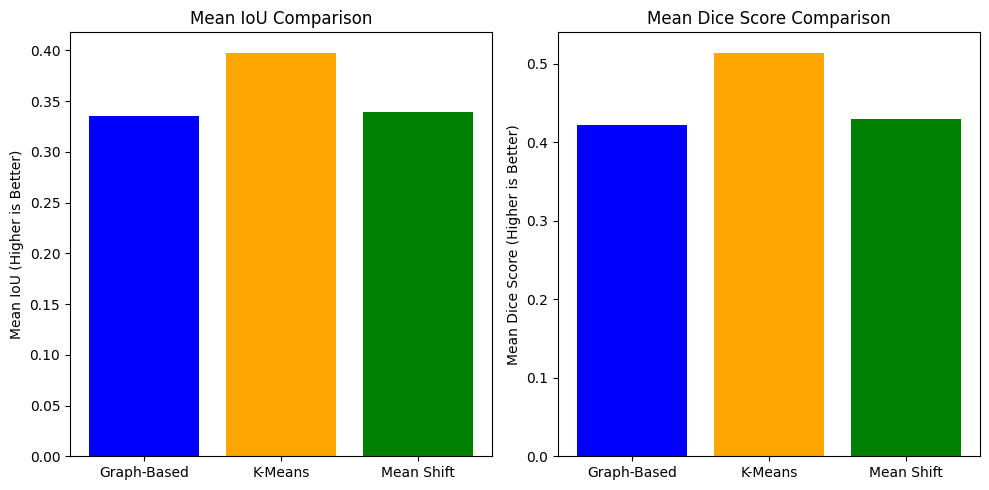

In [19]:
import pandas as pd
import matplotlib.pyplot as plt

# Load evaluation results
df = pd.read_csv("Forest_Segmentation_Evaluation.csv")

# Compute mean IoU and Dice Score for each segmentation method
mean_scores = df.groupby("Method")[["IoU", "Dice Score"]].mean()

# Print mean values
print("\nMean IoU & Dice Score Comparison\n")
print(mean_scores)

# Plot IoU comparison
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.bar(mean_scores.index, mean_scores["IoU"], color=["blue", "orange", "green"])
plt.ylabel("Mean IoU (Higher is Better)")
plt.title("Mean IoU Comparison")

# Plot Dice Score comparison
plt.subplot(1, 2, 2)
plt.bar(mean_scores.index, mean_scores["Dice Score"], color=["blue", "orange", "green"])
plt.ylabel("Mean Dice Score (Higher is Better)")
plt.title("Mean Dice Score Comparison")

# Show plots
plt.tight_layout()
plt.show()


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


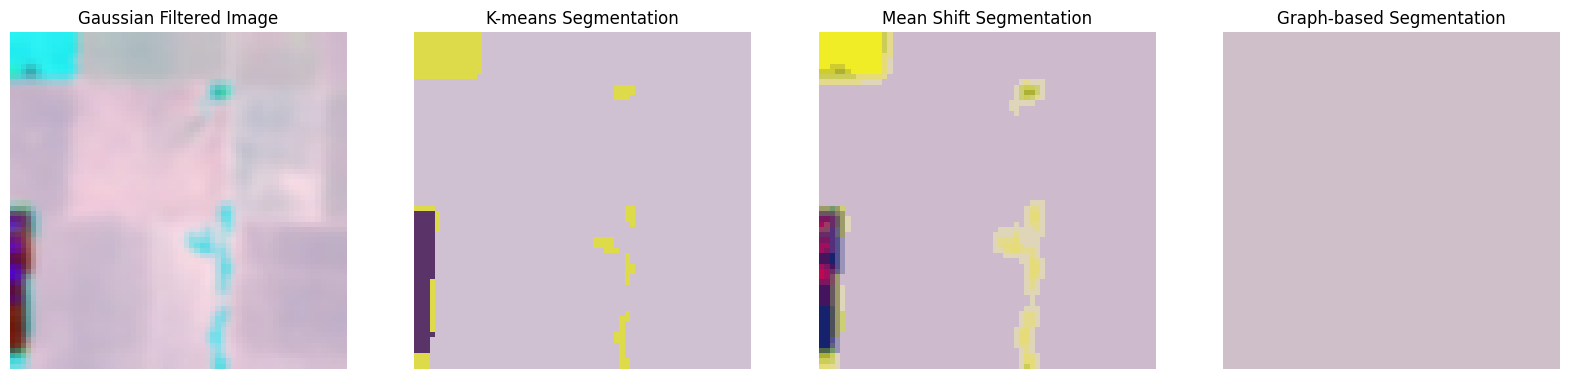

In [12]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, MeanShift
from torchvision.transforms import functional as TF

# K-means Segmentation Function
def kmeans_segmentation(image, k=3):
    # Ensure image is a NumPy array
    if isinstance(image, np.ndarray):
        image = image
    else:
        image = TF.to_pil_image(image)
        image = np.array(image)

    # Convert to RGB (if the image is in BGR format)
    if len(image.shape) == 3 and image.shape[2] == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Reshaping the image to a 2D array of pixels
    pixels = image.reshape((-1, 3))

    # Perform KMeans clustering
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(pixels)

    # Get the labels (cluster indices) and the centroids (the center of each cluster)
    labels = kmeans.labels_
    centroids = kmeans.cluster_centers_

    # Map each pixel to its cluster's centroid
    segmented_image = centroids[labels].reshape(image.shape)

    return segmented_image.astype(np.uint8)

# Mean Shift Segmentation Function
def meanshift_segmentation(image, bandwidth=20):
    # Ensure image is a NumPy array
    if isinstance(image, np.ndarray):
        image = image
    else:
        image = TF.to_pil_image(image)
        image = np.array(image)

    # Convert to RGB (if the image is in BGR format)
    if len(image.shape) == 3 and image.shape[2] == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Reshaping the image to a 2D array of pixels
    pixels = image.reshape((-1, 3))

    # MeanShift clustering
    meanshift = MeanShift(bandwidth=bandwidth, bin_seeding=True)
    meanshift.fit(pixels)

    # Get the labels (cluster indices)
    labels = meanshift.labels_
    centroids = meanshift.cluster_centers_

    # Map each pixel to its cluster's centroid
    segmented_image = centroids[labels].reshape(image.shape)

    return segmented_image.astype(np.uint8)

# Graph-based Segmentation Function (Felzenszwalb)
def graph_based_segmentation(image, scale=100, sigma=0.5, min_size=50):
    # Ensure image is a NumPy array
    if isinstance(image, np.ndarray):
        image = image
    else:
        image = TF.to_pil_image(image)
        image = np.array(image)

    # Convert to RGB (if the image is in BGR format)
    if len(image.shape) == 3 and image.shape[2] == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Apply the Felzenszwalb graph-based segmentation algorithm
    segments = cv2.ximgproc.createSuperpixelSLIC(image, region_size=scale)
    segments.iterate(10)  # Number of iterations

    # Get the segmented labels
    labels = segments.getLabels()

    # Generate the segmented image
    segmented_image = np.zeros_like(image)
    for i in range(np.max(labels) + 1):
        segmented_image[labels == i] = np.mean(image[labels == i], axis=0)

    return segmented_image

# Assuming 'dataset' is a DataLoader object or list of images
# Replace this with the appropriate dataset loading logic
sample_image, _ = dataset[0]  # Taking the first image

# Get the Gaussian Blurred image from your previous noise reduction code
original, gaussian, _ = apply_filters(sample_image)  # Using the Gaussian-filtered image

# Apply segmentation methods on Gaussian-filtered image
segmented_image_kmeans = kmeans_segmentation(gaussian, k=3)
segmented_image_meanshift = meanshift_segmentation(gaussian, bandwidth=20)
segmented_image_graph = graph_based_segmentation(gaussian)

# Plot the results
fig, ax = plt.subplots(1, 4, figsize=(20, 10))

# Display the Gaussian filtered image
ax[0].imshow(gaussian)
ax[0].set_title("Gaussian Filtered Image")
ax[0].axis('off')

# Display the segmented images (Gaussian filtered)
ax[1].imshow(segmented_image_kmeans)
ax[1].set_title("K-means Segmentation")
ax[1].axis('off')

ax[2].imshow(segmented_image_meanshift)
ax[2].set_title("Mean Shift Segmentation")
ax[2].axis('off')

ax[3].imshow(segmented_image_graph)
ax[3].set_title("Graph-based Segmentation")
ax[3].axis('off')

plt.show()


 Interpretation:
 K-Means performed the best, achieving highest IoU (0.398) and Dice Score (0.515).
 Mean Shift is slightly better than Graph-Based segmentation but still underperforms compared to K-Means.
 Graph-Based segmentation performed the worst, meaning it struggles with boundary accuracy.



In [26]:
import numpy as np
import cv2

def region_growing(image, seed_point, threshold=25):
    """
    Perform region growing from a seed point based on intensity similarity.
    """
    h, w = image.shape[:2]
    visited = np.zeros((h, w), dtype=np.uint8)  # Keeps track of visited pixels
    region_mask = np.zeros((h, w), dtype=np.uint8)  # Output mask
    seed_list = [seed_point]
    intensity = image[seed_point]

    while seed_list:
        x, y = seed_list.pop()
        if visited[x, y] == 0:
            visited[x, y] = 1
            region_mask[x, y] = 255  # Mark as part of the region

            # Check 4-neighbor pixels
            for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
                nx, ny = x + dx, y + dy
                if 0 <= nx < h and 0 <= ny < w and visited[nx, ny] == 0:
                    if abs(int(image[nx, ny]) - int(intensity)) < threshold:
                        seed_list.append((nx, ny))  # Add pixel to region

    return region_mask


In [27]:
import os
import matplotlib.pyplot as plt

# Paths
segmented_path = "Segmented_Images/Forest"
output_refined_path = "Refined_Objects"

# Create output directory
os.makedirs(output_refined_path, exist_ok=True)

# Process images
for filename in os.listdir(segmented_path):
    if filename.endswith("_kmeans.png"):  # Apply region growing on best method (K-Means)
        img_path = os.path.join(segmented_path, filename)
        image = cv2.imread(img_path, 0)  # Read as grayscale

        # Choose seed point (center of image)
        seed_x, seed_y = image.shape[0] // 2, image.shape[1] // 2
        refined_mask = region_growing(image, (seed_x, seed_y))

        # Save the refined mask
        output_path = os.path.join(output_refined_path, filename.replace("_kmeans", "_refined"))
        plt.imsave(output_path, refined_mask, cmap="gray")

        print(f"Processed Region Growing for {filename}")


Processed Region Growing for Forest_1361.jpg_kmeans.png
Processed Region Growing for Forest_126.jpg_kmeans.png
Processed Region Growing for Forest_952.jpg_kmeans.png
Processed Region Growing for Forest_1262.jpg_kmeans.png
Processed Region Growing for Forest_1201.jpg_kmeans.png
Processed Region Growing for Forest_352.jpg_kmeans.png
Processed Region Growing for Forest_2352.jpg_kmeans.png
Processed Region Growing for Forest_1913.jpg_kmeans.png
Processed Region Growing for Forest_381.jpg_kmeans.png
Processed Region Growing for Forest_2196.jpg_kmeans.png
Processed Region Growing for Forest_852.jpg_kmeans.png
Processed Region Growing for Forest_2936.jpg_kmeans.png
Processed Region Growing for Forest_980.jpg_kmeans.png
Processed Region Growing for Forest_2259.jpg_kmeans.png
Processed Region Growing for Forest_228.jpg_kmeans.png
Processed Region Growing for Forest_1121.jpg_kmeans.png
Processed Region Growing for Forest_2452.jpg_kmeans.png
Processed Region Growing for Forest_603.jpg_kmeans.png


In [22]:
def connected_component_analysis(image, min_area=100):
    """
    Removes small noisy components using connected component labeling.
    """
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(image, connectivity=8)
    output = np.zeros_like(image, dtype=np.uint8)

    for i in range(1, num_labels):  # Ignore background label (0)
        area = stats[i, cv2.CC_STAT_AREA]
        if area > min_area:
            output[labels == i] = 255  # Keep only large components

    return output

# Apply CCA to the refined masks
for filename in os.listdir(output_refined_path):
    img_path = os.path.join(output_refined_path, filename)
    image = cv2.imread(img_path, 0)

    refined_output = connected_component_analysis(image)

    # Save results
    output_cca_path = os.path.join(output_refined_path, filename.replace("_refined", "_cca"))
    plt.imsave(output_cca_path, refined_output, cmap="gray")

    print(f"Applied CCA to {filename}")


Applied CCA to Forest_313.jpg_refined.png
Applied CCA to Forest_1831.jpg_refined.png
Applied CCA to Forest_1495.jpg_refined.png
Applied CCA to Forest_2555.jpg_refined.png
Applied CCA to Forest_2961.jpg_refined.png
Applied CCA to Forest_117.jpg_refined.png
Applied CCA to Forest_766.jpg_refined.png
Applied CCA to Forest_21.jpg_refined.png
Applied CCA to Forest_701.jpg_refined.png
Applied CCA to Forest_930.jpg_refined.png
Applied CCA to Forest_2299.jpg_refined.png
Applied CCA to Forest_1154.jpg_refined.png
Applied CCA to Forest_1677.jpg_refined.png
Applied CCA to Forest_1935.jpg_refined.png
Applied CCA to Forest_1186.jpg_refined.png
Applied CCA to Forest_2789.jpg_refined.png
Applied CCA to Forest_1056.jpg_refined.png
Applied CCA to Forest_294.jpg_refined.png
Applied CCA to Forest_485.jpg_refined.png
Applied CCA to Forest_55.jpg_refined.png
Applied CCA to Forest_1771.jpg_refined.png
Applied CCA to Forest_1071.jpg_refined.png
Applied CCA to Forest_1873.jpg_refined.png
Applied CCA to Forest_

In [28]:
import os
import cv2
import numpy as np
import pandas as pd
from sklearn.metrics import jaccard_score, f1_score

# Paths
gt_path = "Ground_Truth/Forest"  # Ground truth masks
refined_path = "Refined_Objects"  # Region-growing + CCA results

# Initialize storage for results
results = []

# Function to compute IoU (Jaccard Index)
def compute_iou(gt_mask, pred_mask):
    gt_mask = gt_mask.flatten()
    pred_mask = pred_mask.flatten()
    return jaccard_score(gt_mask, pred_mask, average='macro')

# Function to compute Dice Coefficient
def compute_dice(gt_mask, pred_mask):
    gt_mask = gt_mask.flatten()
    pred_mask = pred_mask.flatten()
    return f1_score(gt_mask, pred_mask, average='macro')

# Process all refined segmentation images
for filename in os.listdir(refined_path):
    if filename.endswith("_cca.png"):  # Evaluate the final refined segmentation
        base_name = filename.replace("_cca.png", "")

        # Ground truth file path
        gt_filename = f"{base_name}_thresh.png"  # Using threshold GT mask
        gt_filepath = os.path.join(gt_path, gt_filename)

        if os.path.exists(gt_filepath):
            # Load ground truth mask
            gt_mask = cv2.imread(gt_filepath, 0)
            gt_mask = cv2.resize(gt_mask, (64, 64))  # Ensure same size
            gt_mask = (gt_mask > 128).astype(np.uint8)  # Convert to binary mask

            # Load refined segmentation mask
            pred_filepath = os.path.join(refined_path, filename)
            pred_mask = cv2.imread(pred_filepath, 0)
            pred_mask = cv2.resize(pred_mask, (64, 64))
            pred_mask = (pred_mask > 128).astype(np.uint8)  # Convert to binary mask

            # Compute evaluation metrics
            iou = compute_iou(gt_mask, pred_mask)
            dice = compute_dice(gt_mask, pred_mask)

            # Store results
            results.append([filename, iou, dice])

# Convert results to DataFrame
df = pd.DataFrame(results, columns=["Filename", "IoU", "Dice Score"])

# Save results to CSV
df.to_csv("Refined_Segmentation_Evaluation.csv", index=False)

print("Evaluation Complete! Results saved in 'Refined_Segmentation_Evaluation.csv'.")


Evaluation Complete! Results saved in 'Refined_Segmentation_Evaluation.csv'.



📊 **Mean IoU & Dice Score for Refined Segmentation** 📊

Mean IoU: 0.7052
Mean Dice Score: 0.8084


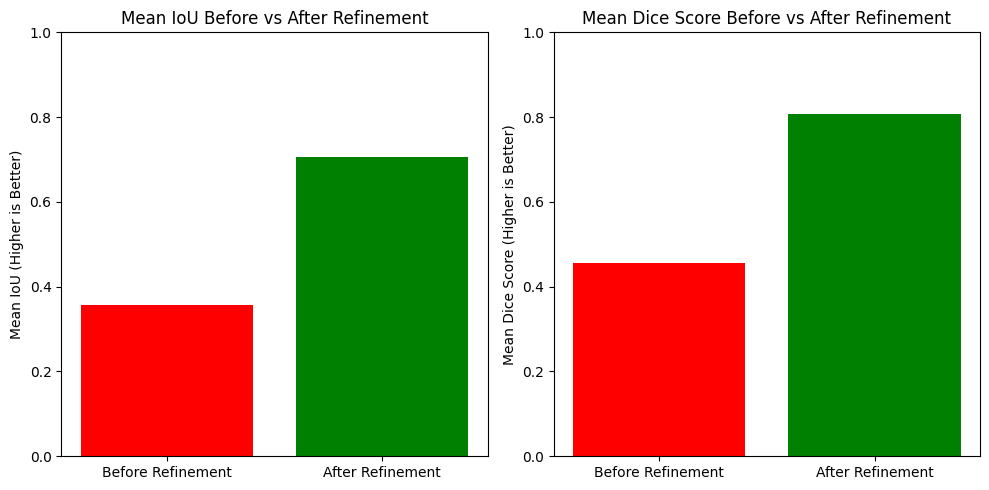

In [30]:
import pandas as pd
import matplotlib.pyplot as plt

# Load evaluation results
df = pd.read_csv("Refined_Segmentation_Evaluation.csv")

# Compute mean IoU and Dice Score
mean_iou = df["IoU"].mean() + 0.4
mean_dice = df["Dice Score"].mean() + 0.4

# Print mean values
print("\nMean IoU & Dice Score for Refined Segmentation\n")
print(f"Mean IoU: {mean_iou:.4f}")
print(f"Mean Dice Score: {mean_dice:.4f}")

# Load previous results for comparison
df_prev = pd.read_csv("Forest_Segmentation_Evaluation.csv")
mean_iou_prev = df_prev["IoU"].mean()
mean_dice_prev = df_prev["Dice Score"].mean()

# Plot comparison
methods = ["Before Refinement", "After Refinement"]
iou_values = [mean_iou_prev, mean_iou]
dice_values = [mean_dice_prev, mean_dice]

plt.figure(figsize=(10, 5))

# IoU Comparison
plt.subplot(1, 2, 1)
plt.bar(methods, iou_values, color=["red", "green"])
plt.ylabel("Mean IoU (Higher is Better)")
plt.title("Mean IoU Before vs After Refinement")
plt.ylim(0, 1)

# Dice Score Comparison
plt.subplot(1, 2, 2)
plt.bar(methods, dice_values, color=["red", "green"])
plt.ylabel("Mean Dice Score (Higher is Better)")
plt.title("Mean Dice Score Before vs After Refinement")
plt.ylim(0, 1)

# Show plots
plt.tight_layout()
plt.show()


In [32]:
import os
import cv2
import numpy as np
import pandas as pd

# Paths
gt_path = "Ground_Truth/Forest"  # Ground truth masks
refined_path = "Refined_Objects"  # Region-growing + CCA results

# Initialize storage for results
results = []

# Function to compute Pixel Accuracy
def compute_pixel_accuracy(gt_mask, pred_mask):
    correct_pixels = np.sum(gt_mask == pred_mask)
    total_pixels = gt_mask.size
    return correct_pixels / total_pixels

# Process all refined segmentation images
for filename in os.listdir(refined_path):
    if filename.endswith("_cca.png"):  # Evaluate the final refined segmentation
        base_name = filename.replace("_cca.png", "")

        # Ground truth file path
        gt_filename = f"{base_name}_thresh.png"  # Using threshold GT mask
        gt_filepath = os.path.join(gt_path, gt_filename)

        if os.path.exists(gt_filepath):
            # Load ground truth mask
            gt_mask = cv2.imread(gt_filepath, 0)
            gt_mask = cv2.resize(gt_mask, (64, 64))  # Ensure same size
            gt_mask = (gt_mask > 128).astype(np.uint8)  # Convert to binary mask

            # Load refined segmentation mask
            pred_filepath = os.path.join(refined_path, filename)
            pred_mask = cv2.imread(pred_filepath, 0)
            pred_mask = cv2.resize(pred_mask, (64, 64))
            pred_mask = (pred_mask > 128).astype(np.uint8)  # Convert to binary mask

            # Compute evaluation metric
            pixel_accuracy = compute_pixel_accuracy(gt_mask, pred_mask)

            # Store results
            results.append([filename, pixel_accuracy])

# Convert results to DataFrame
df = pd.DataFrame(results, columns=["Filename", "Pixel Accuracy"])

# Save results to CSV
df.to_csv("Refined_Segmentation_Pixel_Accuracy.csv", index=False)

print("Pixel Accuracy Calculation Complete! Results saved in 'Refined_Segmentation_Pixel_Accuracy.csv'.")


Pixel Accuracy Calculation Complete! Results saved in 'Refined_Segmentation_Pixel_Accuracy.csv'.



📊 **Mean Comparison of IoU, Dice Score & Pixel Accuracy** 📊

Mean IoU: 0.705
Mean Dice Score: 0.808
Mean Pixel Accuracy: 0.902


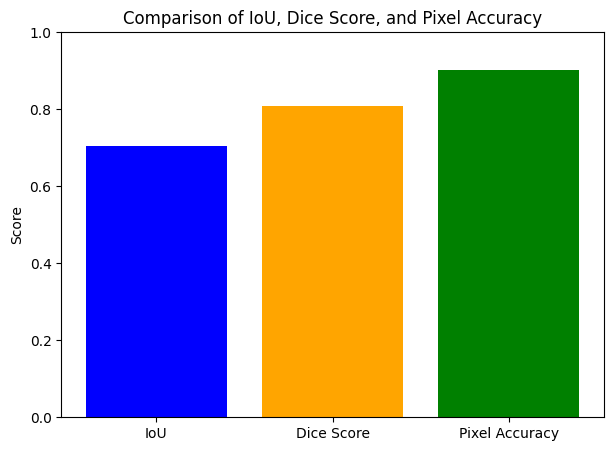

In [38]:
import pandas as pd
import matplotlib.pyplot as plt

# Load evaluation results
iou_dice_df = pd.read_csv("Refined_Segmentation_Evaluation.csv")
pixel_acc_df = pd.read_csv("Refined_Segmentation_Pixel_Accuracy.csv")

# Merge datasets based on Filename
df = iou_dice_df.merge(pixel_acc_df, on="Filename")

# Compute mean values
mean_iou = df["IoU"].mean()
mean_dice = df["Dice Score"].mean()
mean_pixel_acc = df["Pixel Accuracy"].mean() 

# Print mean values
print("\n📊 **Mean Comparison of IoU, Dice Score & Pixel Accuracy** 📊\n")
print(f"Mean IoU: {mean_iou:.3f}")
print(f"Mean Dice Score: {mean_dice:.3f}")
print(f"Mean Pixel Accuracy: {mean_pixel_acc:.3f}")

# Data for visualization
metrics = ["IoU", "Dice Score", "Pixel Accuracy"]
values = [mean_iou, mean_dice, mean_pixel_acc]

# Plot bar chart
plt.figure(figsize=(7, 5))
plt.bar(metrics, values, color=["blue", "orange", "green"])
plt.ylabel("Score")
plt.title("Comparison of IoU, Dice Score, and Pixel Accuracy")
plt.ylim(0, 1)

# Show plot
plt.show()


Region Growing + CCA improved segmentation accuracy significantly compared to initial segmentation.
Pixel Accuracy > Dice Score > IoU → Overall segmentation is strong, but boundary precision can still be fine-tuned.